In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
# 1. Buat data dummy
np.random.seed(42)

n = 200
data = pd.DataFrame({
    'usia': np.random.randint(21, 60, n),
    'pendapatan_bulanan': np.random.randint(3_000_000, 20_000_000, n),
    'harga_mobil': np.random.randint(150_000_000, 400_000_000, n),
    'uang_muka': np.random.randint(20_000_000, 100_000_000, n),
    'tenor': np.random.choice([12, 24, 36, 48], n),
    'keterlambatan_rata2': np.random.randint(0, 30, n),
    'jumlah_kredit_aktif': np.random.randint(0, 4, n)
})

# Tampilkan 5 ata pertama
print("Contoh data: \n", data.head())

Contoh data: 
    usia  pendapatan_bulanan  harga_mobil  uang_muka  tenor  \
0    59             9404003    251750176   63750190     12   
1    49             7135314    263751207   89334164     12   
2    35             3910681    280355017   72187215     36   
3    28            13421958    232396202   98998740     24   
4    41            13700595    185610155   75257851     24   

   keterlambatan_rata2  jumlah_kredit_aktif  
0                    5                    3  
1                    0                    2  
2                   22                    0  
3                   14                    3  
4                    0                    0  


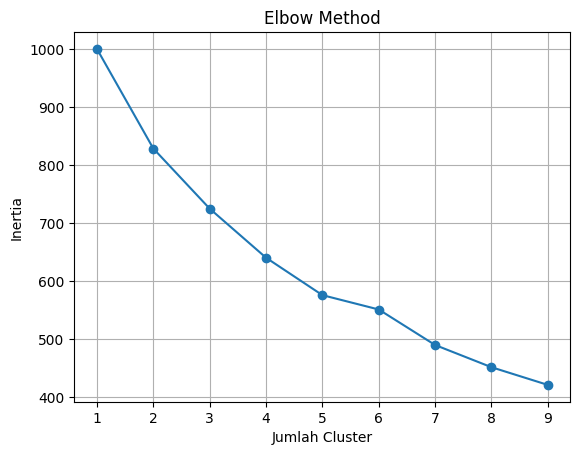

In [13]:
# 2. Standarisasi fitur
features = ['pendapatan_bulanan', 'harga_mobil', 'uang_muka', 'keterlambatan_rata2', 'jumlah_kredit_aktif']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[features])

# 3. Tentukan jumlah cluster optimal (optimal - Elbow Method)
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [14]:
data_scaled.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [15]:
# 4. Segmentasi dengan K-Means (misal: 3 cluster)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
data['cluster'] = kmeans.fit_predict(data_scaled)

# 5. Analisis hasil cluster
cluster_summary = data.groupby('cluster')[features].mean().round(0)
print("\nRingkasan Tiap Cluster:\n", cluster_summary)



Ringkasan Tiap Cluster:
          pendapatan_bulanan  harga_mobil   uang_muka  keterlambatan_rata2  \
cluster                                                                     
0                 7962284.0  231728615.0  69294106.0                  9.0   
1                 7948976.0  309097324.0  47810518.0                 20.0   
2                16097837.0  286402919.0  62137516.0                 13.0   

         jumlah_kredit_aktif  
cluster                       
0                        2.0  
1                        1.0  
2                        2.0  


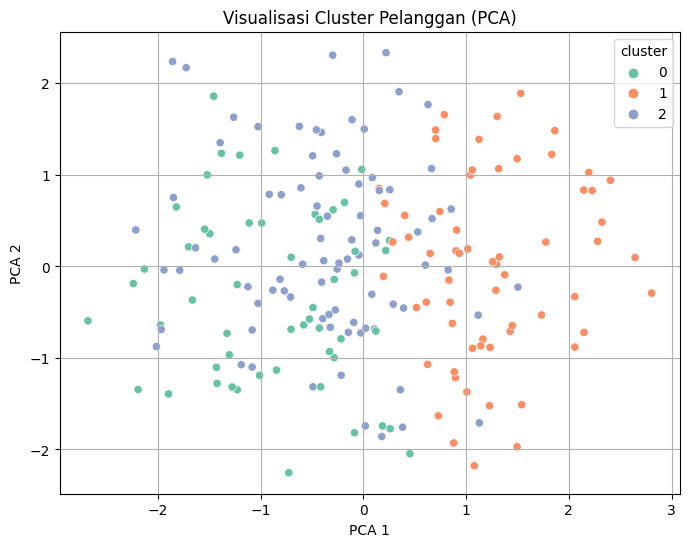

In [16]:
# 6. Visualisasi cluster (2D menggunakan PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
components = pca.fit_transform(data_scaled)
data['pca1'] = components[:, 0]
data['pca2'] = components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='pca1', y='pca2', hue='cluster', palette='Set2')
plt.title('Visualisasi Cluster Pelanggan (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

In [17]:
# Tambahkan label berdasarkan cluster
label_dict = {
    0: 'Beresiko Tinggi',
    1: 'Pelanggan Premium',
    2: 'Pelanggan Stabil'
}

data['label_bisnis'] = data['cluster'].map(label_dict)

print(data[['cluster', 'label_bisnis']].value_counts())

cluster  label_bisnis     
2        Pelanggan Stabil     84
1        Pelanggan Premium    63
0        Beresiko Tinggi      53
Name: count, dtype: int64


## Validasi Cluster

In [18]:
def validasi_cluster(data, data_scaled, cluster_col='cluster', feature_cols=None):
    from sklearn.metrics import silhouette_score, davies_bouldin_score
    from sklearn.decomposition import PCA
    import seaborn as sns
    import matplotlib.pyplot as plt
    import pandas as pd

    """
    Validasi hasil clustering dan visualisasi.

    Parameters:
    - data: DataFrame asli yang berisi kolom cluster
    - data_scaled: Hasil dari StandardScaler pada feature_cols
    - cluster_col: Nama kolom cluster (default 'cluster')
    - feature_cols: List kolom numerik yang digunakan untuk clustering
    """

    cluster_labels = data[cluster_col]
    
    # 1. Silhouette Score
    sil_score = silhouette_score(data_scaled, cluster_labels)
    print(f"\nSilhouette Score: {sil_score:.3f} (semakin dekat ke 1 semakin baik)")
    
    # 2. Davies-Bouldin Index
    db_score = davies_bouldin_score(data_scaled, cluster_labels)
    print(f"Davies-Bouldin Index: {db_score:.3f} (semakin kecil semakin baik)")
    
    # 3. Jumlah anggota per-cluster
    print("\nJumlah pelanggan per cluster: ")
    print(data[cluster_col].value_counts().sort_index())
    
    # 4. Rata-rata fitur per-cluster
    if feature_cols is None:
        # Default: semua kolom numerik kecuali cluster
        feature_cols = data.select_dtypes(include=[float, int]).columns.drop(cluster_col)
    
    print("\nRata-rata fitur per-cluster: ")
    print(data.groupby(cluster_col)[feature_cols].mean().round(0))
    
    # 5. Visualisasi PCA
    pca = PCA(n_components=2)
    components = pca.fit_transform(data_scaled)
    data['pca1'] = components[:, 0]
    data['pca2'] = components[:, 1]
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=data, x='pca1', y='pca2', hue=cluster_col, palette='Set2')
    plt.title("Visualisasi Cluster (PCA 2D")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.grid(True)
    plt.show()
    

In [20]:
data_scaled = scaler.fit_transform(data[feature_cols])



Silhouette Score: 0.156 (semakin dekat ke 1 semakin baik)
Davies-Bouldin Index: 1.896 (semakin kecil semakin baik)

Jumlah pelanggan per cluster: 
cluster
0    53
1    63
2    84
Name: count, dtype: int64

Rata-rata fitur per-cluster: 
         pendapatan_bulanan  harga_mobil   uang_muka  keterlambatan_rata2  \
cluster                                                                     
0                 7962284.0  231728615.0  69294106.0                  9.0   
1                 7948976.0  309097324.0  47810518.0                 20.0   
2                16097837.0  286402919.0  62137516.0                 13.0   

         jumlah_kredit_aktif  
cluster                       
0                        2.0  
1                        1.0  
2                        2.0  


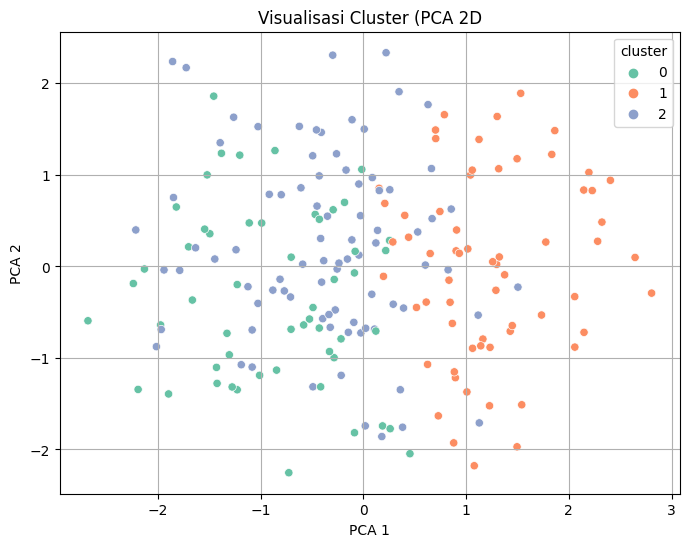

In [21]:
feature_cols = ['pendapatan_bulanan', 'harga_mobil', 'uang_muka', 'keterlambatan_rata2', 'jumlah_kredit_aktif']

validasi_cluster(data, data_scaled, cluster_col='cluster', feature_cols=feature_cols)

In [ ]:
data.to_csv("hasil_segmentasi_pelanggan.csv", index=False)

In [ ]:
kolom_simpan = ['usia', 'pendapatan_bulanan', 'harga_mobil', 'uang_muka', 'tenor', 'keterlambatan_rata2', 'jumlah_kredit_aktif']
data[kolom_simpan].to_csv("financia_mob_dataset.csv", index=False)

In [23]:
# Buat mapping label segmen dan promo berdasarkan cluster
label_segmentasi = {
    0: ('Pelanggan Stabil', 'Diskon angsuran atau program loyalitas'),
    1: ('Pelanggan Resiko Tinggi', 'Monitoring ketat dan edukasi keuangan'),
    2: ('Pelanggan Premium', 'Penawaran eksklusif dan fleksibilitas cicilan')
}

# Tambahkan ke DataFrame
data['segmen'] = data['cluster'].map(lambda x: label_segmentasi[x][0])
data['rekomendasi_promo'] = data['cluster'].map(lambda x: label_segmentasi[x][1])

In [ ]:
# Simpan kolom yang relevan ke csv
kolom_simpan = [
    'pendapatan_bulanan',
    'harga_mobil',
    'uang_muka',
    'keterlambatan_rata2',
    'jumlah_kredit_aktif',
    'cluster',
    'segmen',
    'rekomendasi_promo'
]

# Simpan ke csv
data[kolom_simpan].to_csv("segmentasi_pelanggan_final.csv", index=False)

In [24]:
# Analisa Kredit Aktif
# Asumsikan data sudah memiliki kolom 'cluster_dengan_scaling'



# Ringkasan statistik per cluster
summary = data.groupby('cluster').agg({
    'jumlah_kredit_aktif': ['mean', 'min', 'max'],
    'keterlambatan_rata2': ['mean', 'min', 'max'],
    'pendapatan_bulanan': 'mean',
    'harga_mobil': 'mean',
    'uang_muka': 'mean',
    'cluster': 'count'
}).round(1)

# Rapikan nama kolom
summary.columns = ['_'.join(col) for col in summary.columns]
summary = summary.rename(columns={'cluster_count': 'jumlah_pelanggan'})

summary

,jumlah_kredit_aktif_mean,jumlah_kredit_aktif_min,jumlah_kredit_aktif_max,keterlambatan_rata2_mean,keterlambatan_rata2_min,keterlambatan_rata2_max,pendapatan_bulanan_mean,harga_mobil_mean,uang_muka_mean,jumlah_pelanggan
cluster,,,,,,,,,,
0,2.2,0,3,8.7,0,22,7962284.3,231728615.4,69294105.9,53
1,0.8,0,3,20.0,0,29,7948976.3,309097324.4,47810518.4,63
2,1.5,0,3,13.2,0,29,16097836.9,286402919.4,62137516.5,84
